In [192]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

import pathlib

In [193]:
suffix = "_mscred"

In [194]:
file_path = "src/magnetics_diagnostic_analysis/data"
path = pathlib.Path().absolute().parent.parent.parent / file_path / f"train{suffix}.nc"

with (xr.open_dataset(path) as train):
    #subset = train.sel(shot_id=shots[])
    data_train = train.load()

In [195]:
print(data_train)
print(data_train.data_vars)

<xarray.Dataset> Size: 165MB
Dimensions:                                   (time: 149760,
                                               b_field_pol_probe_cc_channel: 5,
                                               b_field_pol_probe_ccbv_channel: 40,
                                               b_field_pol_probe_obr_channel: 18,
                                               b_field_pol_probe_obv_channel: 18,
                                               b_field_pol_probe_omv_channel: 3,
                                               b_field_tor_probe_cc_channel: 3,
                                               b_field_tor_probe_saddle_voltage_channel: 12,
                                               flux_loop_channel: 15,
                                               b_field_tor_probe_omaha_channel: 4,
                                               b_field_tor_probe_saddle_field_channel: 12)
Coordinates:
  * time                                      (time) float64 1MB 0.1585 

### 1. Variable visualization

In [196]:
ip = data_train["ip"]
ip_values = ip.values
time = data_train.time.values
index = data_train.shot_index.values

ip_values

array([776396.4375    , 775329.8125    , 774706.4375    , ...,
       604672.75      , 604516.00000001, 604233.56250007], shape=(149760,))

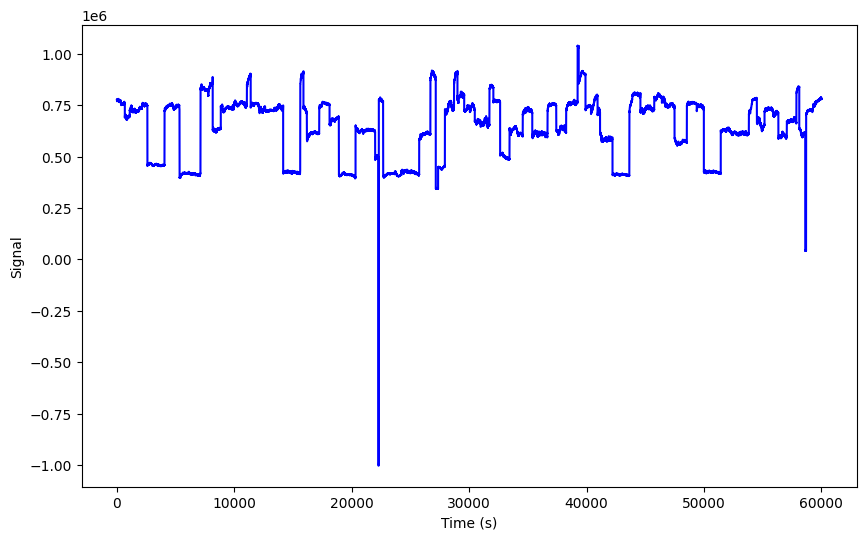

In [197]:
mask0 = (index == 1)

figure, ax = plt.subplots(figsize=(10, 6))
ax.plot(ip_values[:60000], label="Shot 0", color="blue")
ax.set_xlabel("Time (s)")
ax.set_ylabel("Signal")
plt.show()


### 2. NaN proportion for each variables

Goal: find empty variables


In [198]:
def compute_nan_proportions_variables(data: xr.Dataset, sorted: bool = False, ascend_sorting: bool = False) -> pd.DataFrame:
    """
    Compute the proportion of NaN values for each variable in the dataset.

    Parameters
    data_train (xr.Dataset): The input dataset containing variables to analyze.
    sorted (bool): If True, sort the results by NaN proportion in descending order.

    Returns
    pd.DataFrame: A DataFrame containing the variable names, channel names (if applicable), and their NaN proportions.
    """
    results = []
    best_channel = []

    # Parcours des variables du Dataset
    for var_name, da in data.data_vars.items():
        dims = da.dims
        
        if 'time' not in dims:
            # Skip variables that do not have a time dimension
            continue

        if len(dims) == 1:
            # 1D variable (time)
            total = da.sizes['time']
            n_nan = da.isnull().sum().item()
            prop = 100 * n_nan / total
            results.append((var_name, None, prop))
            if prop < 0.1:
                best_channel.append((var_name, None, prop))


        elif len(dims) == 2:
            # 2D variable (time, channel)
            time_dim, channel_dim = dims
            for i, channel in enumerate(data[channel_dim].values):
                series = da.isel({channel_dim: i})
                total = series.sizes[time_dim]
                n_nan = series.isnull().sum().item()
                prop = 100 * n_nan / total
                results.append((var_name, str(channel), prop))
                if prop < 0.1:
                    best_channel.append((var_name, str(channel), prop))

    df_nan_stats = pd.DataFrame(results, columns=['variable', 'channel', 'nan_ratio'])

    if sorted:
        df_nan_stats = df_nan_stats.sort_values(by='nan_ratio', ascending=ascend_sorting).reset_index(drop=True)

    return df_nan_stats, best_channel

In [199]:
result_var, best_channels = compute_nan_proportions_variables(data=data_train, sorted=True, ascend_sorting=True)
result_var

,variable,channel,nan_ratio
0,b_field_pol_probe_ccbv_field,AMB_CCBV07,0.0
1,b_field_pol_probe_ccbv_field,AMB_CCBV05,0.0
2,b_field_pol_probe_ccbv_field,AMB_CCBV08,0.0
3,b_field_pol_probe_ccbv_field,AMB_CCBV09,0.0
4,b_field_pol_probe_ccbv_field,AMB_CCBV04,0.0
...,...,...,...
132,b_field_pol_probe_obv_field,AMB_OBV10,100.0
133,b_field_tor_probe_saddle_field,ASM_SAD/M09,100.0
134,b_field_tor_probe_saddle_field,ASM_SAD/M10,100.0
135,b_field_tor_probe_saddle_field,ASM_SAD/M11,100.0


In [200]:
print("Number of variables with NaN proportions less than 0.1%: ", len(best_channels))
for chan in best_channels:
    print(f"Variable: {chan[0]}, Channel: {chan[1]}, NaN Proportion: {chan[2]}")

Number of variables with NaN proportions less than 0.1%:  67
Variable: b_field_pol_probe_ccbv_field, Channel: AMB_CCBV03, NaN Proportion: 0.0
Variable: b_field_pol_probe_ccbv_field, Channel: AMB_CCBV04, NaN Proportion: 0.0
Variable: b_field_pol_probe_ccbv_field, Channel: AMB_CCBV05, NaN Proportion: 0.0
Variable: b_field_pol_probe_ccbv_field, Channel: AMB_CCBV07, NaN Proportion: 0.0
Variable: b_field_pol_probe_ccbv_field, Channel: AMB_CCBV08, NaN Proportion: 0.0
Variable: b_field_pol_probe_ccbv_field, Channel: AMB_CCBV09, NaN Proportion: 0.0
Variable: b_field_pol_probe_ccbv_field, Channel: AMB_CCBV11, NaN Proportion: 0.0
Variable: b_field_pol_probe_ccbv_field, Channel: AMB_CCBV12, NaN Proportion: 0.0
Variable: b_field_pol_probe_ccbv_field, Channel: AMB_CCBV14, NaN Proportion: 0.0
Variable: b_field_pol_probe_ccbv_field, Channel: AMB_CCBV15, NaN Proportion: 0.0
Variable: b_field_pol_probe_ccbv_field, Channel: AMB_CCBV16, NaN Proportion: 0.0
Variable: b_field_pol_probe_ccbv_field, Channel:

In [201]:
file_path = "src/magnetics_diagnostic_analysis/results"
path = pathlib.Path().absolute().parent.parent.parent / file_path / f"nan_stats_by_vars{suffix}.csv"
result_var.to_csv(path, index=False)

### 3. NaN proportion for each shot per variables

Goals: Delete shots where too many NaN

In [202]:
def compute_nan_proportions_shots(data: xr.Dataset, sorted: bool = False, ascend_sorting: bool = False) -> pd.DataFrame:
    """
    Compute the proportion of NaN values for each variable in the dataset, grouped by shot.

    Parameters
    data (xr.Dataset): The input dataset containing variables to analyze.
    sorted (bool): If True, sort the results by NaN proportion in descending order.
    ascend_sorting (bool): If True, sort in ascending order; if False, sort in descending order.

    Returns
    pd.DataFrame: A DataFrame containing the variable names, channel names (if applicable), and their NaN proportions per shot.
    """

    shot_index = data['shot_index'].values
    unique_shots = np.unique(shot_index)

    results = []

    for var_name, da in data.data_vars.items():
        dims = da.dims

        if 'time' not in dims:
            continue

        if len(dims) == 1:
            # 1D variable (time)
            row = {'variable': var_name, 'channel': None}
            for shot in unique_shots:
                shot_mask = (shot_index == shot)
                total = shot_mask.sum()
                n_nan = da.isnull().values[shot_mask].sum()
                row[f'shot_{shot}'] = n_nan / total if total > 0 else np.nan
            results.append(row)

        elif len(dims) == 2:
            # 2D variable (time, channel)
            _, channel_dim = dims
            for i, channel_val in enumerate(data[channel_dim].values):
                row = {'variable': var_name, 'channel': str(channel_val)}
                series = da.isel({channel_dim: i})
                for shot in unique_shots:
                    shot_mask = (shot_index == shot)
                    total = shot_mask.sum()
                    n_nan = series.isnull().values[shot_mask].sum()
                    row[f'shot_{shot}'] = n_nan / total if total > 0 else np.nan
                results.append(row)

    df_nan_by_shot = pd.DataFrame(results)

    if sorted:
        # Find the maximum NaN proportion across all shots for each variable/channel
        max_nan_cols = [col for col in df_nan_by_shot.columns if col.startswith('shot_')]
        df_nan_by_shot['max_nan_ratio'] = df_nan_by_shot[max_nan_cols].max(axis=1)
        df_nan_by_shot = df_nan_by_shot.sort_values(by='max_nan_ratio', ascending=ascend_sorting).reset_index(drop=True)
    
    return df_nan_by_shot

In [203]:
result_per_shot = compute_nan_proportions_shots(data=data_train, sorted=False)
result_per_shot

,variable,channel,shot_0,shot_1,shot_2,shot_3,shot_4,shot_5,shot_6,shot_7,...,shot_190,shot_191,shot_192,shot_193,shot_194,shot_195,shot_196,shot_197,shot_198,shot_199
0,power_radiated,None,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,b_field_pol_probe_cc_field,xmc/CC/MV/201,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
2,b_field_pol_probe_cc_field,xmc/CC/MV/210,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
3,b_field_pol_probe_cc_field,xmc/CC/MV/220,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,b_field_pol_probe_cc_field,xmc/CC/MV/230,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132,b_field_tor_probe_saddle_field,ASM_SAD/M08,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
133,b_field_tor_probe_saddle_field,ASM_SAD/M09,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
134,b_field_tor_probe_saddle_field,ASM_SAD/M10,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
135,b_field_tor_probe_saddle_field,ASM_SAD/M11,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [204]:
file_path = "src/magnetics_diagnostic_analysis/results"
path = pathlib.Path().absolute().parent.parent.parent / file_path / f"nan_stats_by_shot{suffix}.csv"
result_per_shot.to_csv(path, index=False)